In [3]:
!pip install kaggle --quiet
import os, shutil

# Create kaggle directory
os.environ['KAGGLE_CONFIG_DIR'] = '/root/.kaggle'
kaggle_dir = "/root/.kaggle"
os.makedirs(kaggle_dir, exist_ok=True)

# Search for kaggle.json
kaggle_found = False
for path in ["kaggle.json", "/content/kaggle.json", "./kaggle.json", "sample_data/kaggle.json"]:
    if os.path.exists(path):
        shutil.copy(path, f"{kaggle_dir}/kaggle.json")
        os.chmod(f"{kaggle_dir}/kaggle.json", 0o600)
        print("✓ Found and configured kaggle.json")
        kaggle_found = True
        break

if not kaggle_found:
    raise SystemExit("ERROR: Upload kaggle.json first!")

print("✓ kaggle.json verified at:", kaggle_dir)


✓ Found and configured kaggle.json
✓ kaggle.json verified at: /root/.kaggle


In [4]:
import kaggle
import os
import shutil
import pandas as pd
from pathlib import Path

kaggle.api.authenticate()

BASE_DIR = "emotion_datasets"
COMBINED_DIR = "combined_emotions"
METADATA_FILE = "dataset_metadata.csv"

DATASETS = {
    "crema_d": "ejlok1/cremad",
    "ravdess": "uwrfkaggler/ravdess-emotional-speech-audio",
    "savee": "ejlok1/surrey-audiovisual-expressed-emotion-savee",
    "tess": "ejlok1/toronto-emotional-speech-set-tess",
    "meld": "shivamburnwal/meld-dataset"
}

EMOTION_MAPPING = {
    "ANG": "angry", "DIS": "disgust", "FEA": "fear", "HAP": "happy", "NEU": "neutral", "SAD": "sad",
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad", "05": "angry", "06": "fear",
    "07": "disgust", "08": "surprise",
    "a": "angry", "d": "disgust", "f": "fear", "h": "happy", "n": "neutral", "sa": "sad", "su": "surprise",
    "angry": "angry", "disgust": "disgust", "fear": "fear", "happy": "happy", "neutral": "neutral",
    "ps": "surprise", "sad": "sad",
    "anger": "angry", "joy": "happy", "sadness": "sad", "surprise": "surprise",
    "fear": "fear", "disgust": "disgust", "neutral": "neutral"
}


In [5]:
def parse_crema_d(name):
    parts = name.split("_")
    if len(parts) >= 3:
        return EMOTION_MAPPING.get(parts[2], "unknown")
    return "unknown"

def parse_ravdess(name):
    parts = name.split("-")
    if len(parts) >= 3:
        return EMOTION_MAPPING.get(parts[2], "unknown")
    return "unknown"

def parse_savee(name):
    parts = name.split("_")
    if len(parts) >= 2:
        code = ''.join([c for c in parts[1].replace(".wav", "") if c.isalpha()])
        return EMOTION_MAPPING.get(code, "unknown")
    return "unknown"

def parse_tess(name):
    parts = name.lower().split("_")
    if len(parts) >= 3:
        emotion = parts[2].replace(".wav", "")
        return EMOTION_MAPPING.get(emotion, "unknown")
    return "unknown"

def parse_meld(name):
    name = name.lower()
    for key, val in EMOTION_MAPPING.items():
        if key in name:
            return val
    return "unknown"

PARSERS = {
    "crema_d": parse_crema_d,
    "ravdess": parse_ravdess,
    "savee": parse_savee,
    "tess": parse_tess,
    "meld": parse_meld
}


In [6]:
def download_datasets():
    os.makedirs(BASE_DIR, exist_ok=True)
    print("Downloading datasets...\n")

    for name, ds in DATASETS.items():
        path = f"{BASE_DIR}/{name}"
        print(f"Downloading {name}...")
        try:
            kaggle.api.dataset_download_files(ds, path=path, unzip=True)
            print(f"✓ {name} downloaded\n")
        except Exception as e:
            print(f"✗ Failed {name}: {e}\n")

download_datasets()



Dataset URL: https://www.kaggle.com/datasets/ejlok1/cremad
✓ crema_d downloaded

Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
✓ ravdess downloaded

Dataset URL: https://www.kaggle.com/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee
✓ savee downloaded

Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
✓ tess downloaded

Dataset URL: https://www.kaggle.com/datasets/shivamburnwal/meld-dataset
✗ Failed meld: 403 Client Error: Forbidden for url: https://www.kaggle.com/api/v1/datasets/download/shivamburnwal/meld-dataset?raw=false



In [7]:
def organize_datasets():
    os.makedirs(COMBINED_DIR, exist_ok=True)
    metadata = []
    count = 0

    for name, parser in PARSERS.items():
        path = f"{BASE_DIR}/{name}"
        print(f"Processing {name}...")

        audio_files = []
        for ext in [".wav", ".mp3", ".flac", ".m4a"]:
            audio_files.extend(Path(path).rglob(f"*{ext}"))

        print(f"  Found {len(audio_files)} files")

        for f in audio_files:
            emotion = parser(f.name)
            if emotion == "unknown":
                continue

            out_dir = f"{COMBINED_DIR}/{emotion}"
            os.makedirs(out_dir, exist_ok=True)

            new_name = f"{name}_{count:06d}_{f.name}"
            dest = f"{out_dir}/{new_name}"

            shutil.copy2(f, dest)

            metadata.append({
                "filename": new_name,
                "original_filename": f.name,
                "dataset": name,
                "emotion": emotion,
                "path": dest
            })
            count += 1

    df = pd.DataFrame(metadata)
    df.to_csv(f"{COMBINED_DIR}/{METADATA_FILE}", index=False)
    print(f"\n✓ Total files organized: {count}")
    return df

df = organize_datasets()


Processing crema_d...
  Found 7442 files
Processing ravdess...
  Found 2880 files
Processing savee...
  Found 480 files
Processing tess...
  Found 5600 files
Processing meld...
  Found 0 files

✓ Total files organized: 16402


In [8]:
print("Dataset Ready!")
print(f"Combined Folder: {COMBINED_DIR}")
print(f"Metadata File: {COMBINED_DIR}/{METADATA_FILE}")


Dataset Ready!
Combined Folder: combined_emotions
Metadata File: combined_emotions/dataset_metadata.csv


In [9]:
# Run this cell first in Colab / Jupyter (only once)
!pip install -q librosa tensorflow scikit-learn matplotlib tqdm seaborn

print("✓ Packages installed/available")


✓ Packages installed/available


In [10]:
import os
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("✓ Imports done")


✓ Imports done


In [11]:
COMBINED_DIR = "combined_emotions"
METADATA_FILE = "dataset_metadata.csv"
MODEL_SAVE_PATH = "emotion_lstm_model.h5"
LABEL_ENCODER_PATH = "label_encoder.npy"

# Audio processing params
SAMPLE_RATE = 22050
DURATION = 3           # seconds to load per file
MAX_PAD_LEN = 130      # frames for MFCC (time steps)

# Model / training params
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001

print("✓ Configuration set")


✓ Configuration set


In [12]:
def extract_features(file_path, max_pad_len=MAX_PAD_LEN, sr=SAMPLE_RATE, duration=DURATION):
    """
    Load audio (fixed duration) and extract 40 MFCCs.
    Returns a (max_pad_len, n_mfcc) array or None on failure.
    """
    try:
        audio, sr = librosa.load(file_path, sr=sr, duration=duration)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        mfccs = mfccs.T  # shape: (time_steps, n_mfcc)

        # pad or truncate
        if mfccs.shape[0] < max_pad_len:
            pad_width = max_pad_len - mfccs.shape[0]
            mfccs = np.pad(mfccs, pad_width=((0, pad_width), (0, 0)), mode='constant')
        else:
            mfccs = mfccs[:max_pad_len, :]

        return mfccs.astype(np.float32)
    except Exception as e:
        # optionally log: print("extract error", file_path, e)
        return None

print("✓ Feature extractor ready")


✓ Feature extractor ready


In [13]:
metadata_path = os.path.join(COMBINED_DIR, METADATA_FILE)
if not os.path.exists(metadata_path):
    raise FileNotFoundError(f"Metadata not found: {metadata_path}. Run dataset combiner first.")

df = pd.read_csv(metadata_path)
print(f"Total files in metadata: {len(df)}")
print(df['emotion'].value_counts())

# Extract features
X = []
y = []

print("\nExtracting MFCCs: (this may take a while depending on #files)")
for _, row in tqdm(df.iterrows(), total=len(df)):
    features = extract_features(row['path'])
    if features is not None:
        X.append(features)
        y.append(row['emotion'])

X = np.array(X)
y = np.array(y)
print(f"\n✓ Extracted features from {len(X)} files")
print("Feature array shape:", X.shape)


Total files in metadata: 16402
emotion
happy       2515
disgust     2515
angry       2515
sad         2515
fear        2515
neutral     2199
surprise    1244
calm         384
Name: count, dtype: int64

Extracting MFCCs: (this may take a while depending on #files)


100%|██████████| 16402/16402 [03:51<00:00, 70.96it/s]



✓ Extracted features from 16402 files
Feature array shape: (16402, 130, 40)


In [14]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Save classes (useful for later inference)
np.save(LABEL_ENCODER_PATH, le.classes_, allow_pickle=True)
print("✓ Label encoder classes saved to", LABEL_ENCODER_PATH)
print("Label mapping:")
for i, label in enumerate(le.classes_):
    print(f"  {i}: {label}")


✓ Label encoder classes saved to label_encoder.npy
Label mapping:
  0: angry
  1: calm
  2: disgust
  3: fear
  4: happy
  5: neutral
  6: sad
  7: surprise


In [15]:
# stratify by class indices
y_indices = y_categorical.argmax(axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.20, random_state=42, stratify=y_indices
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42, stratify=y_train.argmax(axis=1)
)

print("Dataset split:")
print("  Train:", X_train.shape[0])
print("  Val:  ", X_val.shape[0])
print("  Test: ", X_test.shape[0])


Dataset split:
  Train: 11152
  Val:   1969
  Test:  3281


In [16]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, n_mfcc)
num_classes = y_train.shape[1]

model = keras.Sequential([
    layers.Input(shape=input_shape),

    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Dropout(0.3),

    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Dropout(0.3),

    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.4),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),

    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 130, 256)       │       173,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 130, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 130, 128)       │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 130, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 383,304 (1.46 MB)

 Trainable params: 383,304 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, verbose=1
    )
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# Save final model (ModelCheckpoint already saved best)
model.save(MODEL_SAVE_PATH)
print("✓ Model saved to", MODEL_SAVE_PATH)


Epoch 1/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3086 - loss: 1.7632
Epoch 1: val_accuracy improved from -inf to 0.57694, saving model to emotion_lstm_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.3089 - loss: 1.7625 - val_accuracy: 0.5769 - val_loss: 1.0793 - learning_rate: 0.0010
Epoch 2/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5490 - loss: 1.1654
Epoch 2: val_accuracy improved from 0.57694 to 0.57948, saving model to emotion_lstm_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.5490 - loss: 1.1653 - val_accuracy: 0.5795 - val_loss: 1.0299 - learning_rate: 0.0010
Epoch 3/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5807 - loss: 1.0855
Epoch 3: val_accuracy improved from 0.57948 to 0.60183, saving model to emotion_lstm_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.5807 - loss: 1.0854 - val_accuracy: 0.6018 - val_loss: 1.0527 - learning_rate: 0.0010
Epoch 4/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5972 - loss: 1.0575
Epoch 4: val_accuracy did not improve from 0.60183
349/349 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.5972 - loss: 1.0574 - val_accuracy: 0.6018 - val_loss: 0.9767 - learning_rate: 0.0010
Epoch 5/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6202 - loss: 0.9953
Epoch 5: val_accuracy improved from 0.60183 to 0.61300, saving model to emotion_lstm_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.6202 - loss: 0.9952 - val_accuracy: 0.6130 - val_loss: 0.9777 - learning_rate: 0.0010
Epoch 6/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6318 - loss: 0.9625
Epoch 6: val_accuracy improved from 0.61300 to 0.62875, saving model to emotion_lstm_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.6318 - loss: 0.9625 - val_accuracy: 0.6287 - val_loss: 0.9963 - learning_rate: 0.0010
Epoch 7/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6473 - loss: 0.9331
Epoch 7: val_accuracy improved from 0.62875 to 0.65922, saving model to emotion_lstm_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.6473 - loss: 0.9331 - val_accuracy: 0.6592 - val_loss: 0.8792 - learning_rate: 0.0010
Epoch 8/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6561 - loss: 0.9119
Epoch 8: val_accuracy did not improve from 0.65922
349/349 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.6561 - loss: 0.9119 - val_accuracy: 0.6546 - val_loss: 0.9010 - learning_rate: 0.0010
Epoch 9/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6526 - loss: 0.9232
Epoch 9: val_accuracy did not improve from 0.65922
349/349 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.6526 - loss: 0.9231 - val_accuracy: 0.6496 - val_loss: 0.9139 - learning_rate: 0.0010
Epoch 10/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6759 - loss: 0.8644
Epoch 10: val_accuracy improved from 0.65922 to 0.67750, saving model to emotion_lstm_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.6759 - loss: 0.8644 - val_accuracy: 0.6775 - val_loss: 0.8435 - learning_rate: 0.0010
Epoch 11/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6962 - loss: 0.8205
Epoch 11: val_accuracy did not improve from 0.67750
349/349 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.6962 - loss: 0.8206 - val_accuracy: 0.6658 - val_loss: 0.8354 - learning_rate: 0.0010
Epoch 12/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6774 - loss: 0.8544
Epoch 12: val_accuracy improved from 0.67750 to 0.68512, saving model to emotion_lstm_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.6774 - loss: 0.8543 - val_accuracy: 0.6851 - val_loss: 0.8309 - learning_rate: 0.0010
Epoch 13/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6948 - loss: 0.8124
Epoch 13: val_accuracy improved from 0.68512 to 0.69071, saving model to emotion_lstm_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.6948 - loss: 0.8124 - val_accuracy: 0.6907 - val_loss: 0.8136 - learning_rate: 0.0010
Epoch 14/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6969 - loss: 0.7967
Epoch 14: val_accuracy did not improve from 0.69071
349/349 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.6969 - loss: 0.7967 - val_accuracy: 0.6846 - val_loss: 0.8224 - learning_rate: 0.0010
Epoch 15/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7136 - loss: 0.7730
Epoch 15: val_accuracy improved from 0.69071 to 0.70442, saving model to emotion_lstm_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.7136 - loss: 0.7730 - val_accuracy: 0.7044 - val_loss: 0.7978 - learning_rate: 0.0010
Epoch 16/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7271 - loss: 0.7412
Epoch 16: val_accuracy did not improve from 0.70442
349/349 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7271 - loss: 0.7413 - val_accuracy: 0.7019 - val_loss: 0.7910 - learning_rate: 0.0010
Epoch 17/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7258 - loss: 0.7332
Epoch 17: val_accuracy improved from 0.70442 to 0.70696, saving model to emotion_lstm_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.7258 - loss: 0.7332 - val_accuracy: 0.7070 - val_loss: 0.8056 - learning_rate: 0.0010
Epoch 18/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7354 - loss: 0.7119
Epoch 18: val_accuracy did not improve from 0.70696
349/349 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7354 - loss: 0.7119 - val_accuracy: 0.7019 - val_loss: 0.7986 - learning_rate: 0.0010
Epoch 19/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7462 - loss: 0.6806
Epoch 19: val_accuracy improved from 0.70696 to 0.71407, saving model to emotion_lstm_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7461 - loss: 0.6807 - val_accuracy: 0.7141 - val_loss: 0.7689 - learning_rate: 0.0010
Epoch 20/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7476 - loss: 0.6905
Epoch 20: val_accuracy improved from 0.71407 to 0.72219, saving model to emotion_lstm_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.7476 - loss: 0.6905 - val_accuracy: 0.7222 - val_loss: 0.7459 - learning_rate: 0.0010
Epoch 21/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7567 - loss: 0.6649
Epoch 21: val_accuracy improved from 0.72219 to 0.73235, saving model to emotion_lstm_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.7567 - loss: 0.6649 - val_accuracy: 0.7324 - val_loss: 0.7136 - learning_rate: 0.0010
Epoch 22/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7583 - loss: 0.6556
Epoch 22: val_accuracy improved from 0.73235 to 0.73641, saving model to emotion_lstm_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.7583 - loss: 0.6556 - val_accuracy: 0.7364 - val_loss: 0.7557 - learning_rate: 0.0010
Epoch 23/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7687 - loss: 0.6366
Epoch 23: val_accuracy improved from 0.73641 to 0.74606, saving model to emotion_lstm_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.7686 - loss: 0.6366 - val_accuracy: 0.7461 - val_loss: 0.7348 - learning_rate: 0.0010
Epoch 24/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7721 - loss: 0.6310
Epoch 24: val_accuracy did not improve from 0.74606
349/349 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.7720 - loss: 0.6310 - val_accuracy: 0.7237 - val_loss: 0.7505 - learning_rate: 0.0010
Epoch 25/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7781 - loss: 0.6134
Epoch 25: val_accuracy did not improve from 0.74606
349/349 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.7780 - loss: 0.6135 - val_accuracy: 0.7273 - val_loss: 0.7436 - learning_rate: 0.0010
Epoch 26/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7768 - loss: 0.6089
Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 26: val_accuracy did not improve from 0.74606
349/349 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.7768 - loss: 0.6

349/349 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.8004 - loss: 0.5489 - val_accuracy: 0.7537 - val_loss: 0.6974 - learning_rate: 5.0000e-04
Epoch 28/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8143 - loss: 0.5078
Epoch 28: val_accuracy did not improve from 0.75368
349/349 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.8143 - loss: 0.5077 - val_accuracy: 0.7532 - val_loss: 0.7162 - learning_rate: 5.0000e-04
Epoch 29/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8214 - loss: 0.4914
Epoch 29: val_accuracy did not improve from 0.75368
349/349 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.8214 - loss: 0.4915 - val_accuracy: 0.7532 - val_loss: 0.7062 - learning_rate: 5.0000e-04
Epoch 30/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8217 - loss: 0.4852
Epoch 30: val_accuracy improved from 0.75368 to 0.76130, saving model to emotion_lstm_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.8217 - loss: 0.4851 - val_accuracy: 0.7613 - val_loss: 0.7265 - learning_rate: 5.0000e-04
Epoch 31/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8365 - loss: 0.4645
Epoch 31: val_accuracy did not improve from 0.76130
349/349 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.8365 - loss: 0.4645 - val_accuracy: 0.7572 - val_loss: 0.7176 - learning_rate: 5.0000e-04
Epoch 32/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8345 - loss: 0.4588
Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 32: val_accuracy did not improve from 0.76130
349/349 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.8345 - loss: 0.4587 - val_accuracy: 0.7527 - val_loss: 0.7468 - learning_rate: 5.0000e-04
Epoch 33/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8586 - loss: 0.3997
Epoch 33: val_accuracy improved from 0.76130 to 0.76943, saving model to emotion_lstm_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.8586 - loss: 0.3997 - val_accuracy: 0.7694 - val_loss: 0.7224 - learning_rate: 2.5000e-04
Epoch 34/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8579 - loss: 0.3892
Epoch 34: val_accuracy improved from 0.76943 to 0.77603, saving model to emotion_lstm_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.8579 - loss: 0.3892 - val_accuracy: 0.7760 - val_loss: 0.7375 - learning_rate: 2.5000e-04
Epoch 35/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8724 - loss: 0.3577
Epoch 35: val_accuracy did not improve from 0.77603
349/349 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.8724 - loss: 0.3577 - val_accuracy: 0.7537 - val_loss: 0.7904 - learning_rate: 2.5000e-04
Epoch 36/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8640 - loss: 0.3726
Epoch 36: val_accuracy did not improve from 0.77603
349/349 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.8641 - loss: 0.3726 - val_accuracy: 0.7664 - val_loss: 0.7645 - learning_rate: 2.5000e-04
Epoch 37/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8757 - loss: 0.3328
Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 37: val_accuracy did not improve from 0.77603
349/349 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.8756

✓ Model saved to emotion_lstm_model.h5


In [18]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Predictions & report
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

cm = confusion_matrix(y_true_classes, y_pred_classes)
print("\nConfusion matrix:\n", cm)


Test loss: 0.6885
Test accuracy: 0.7553 (75.53%)

Classification report:
              precision    recall  f1-score   support

       angry       0.80      0.84      0.82       503
        calm       0.81      0.88      0.84        77
     disgust       0.70      0.70      0.70       503
        fear       0.77      0.67      0.72       503
       happy       0.74      0.67      0.71       503
     neutral       0.70      0.83      0.76       440
         sad       0.72      0.71      0.71       503
    surprise       0.96      0.94      0.95       249

    accuracy                           0.76      3281
   macro avg       0.77      0.78      0.78      3281
weighted avg       0.76      0.76      0.75      3281


Confusion matrix:
 [[424   0  25   8  31  12   3   0]
 [  0  68   0   0   0   7   2   0]
 [ 32   0 354  14  17  36  46   4]
 [ 10   0  31 337  38  24  60   3]
 [ 57   0  27  42 339  29   6   3]
 [  1   2  23  10  16 365  23   0]
 [  4  14  48  23   5  51 358   0]
 [  3   0  

✓ Saved training_history.png


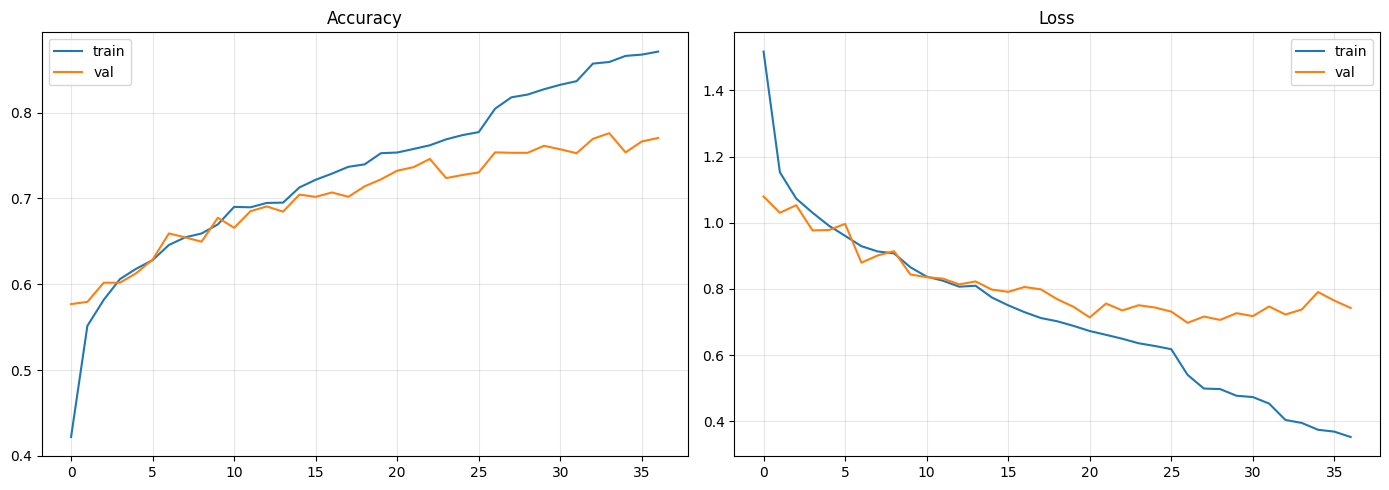

✓ Saved confusion_matrix.png


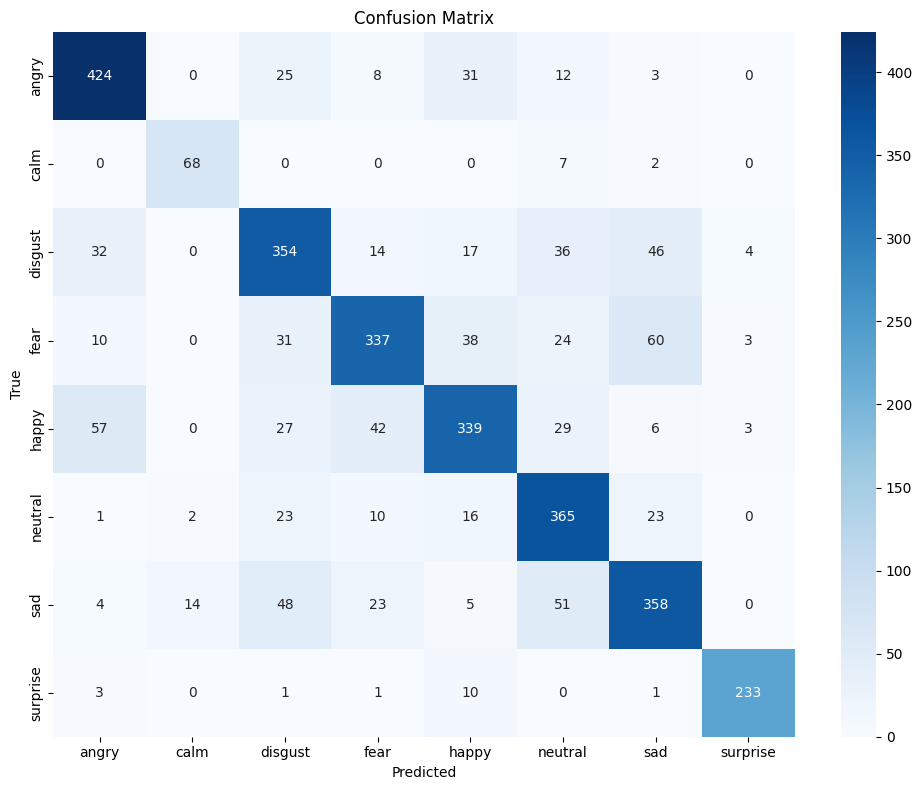

In [19]:
import seaborn as sns

# Training history plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['accuracy'], label='train')
axes[0].plot(history.history['val_accuracy'], label='val')
axes[0].set_title('Accuracy')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(history.history['loss'], label='train')
axes[1].plot(history.history['val_loss'], label='val')
axes[1].set_title('Loss')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
print("✓ Saved training_history.png")
plt.show()

# Confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("✓ Saved confusion_matrix.png")
plt.show()


In [20]:
from sklearn.metrics import classification_report
import pandas as pd

# Generate text report
report = classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=le.classes_,
    output_dict=True
)

# Convert to DataFrame
df_report = pd.DataFrame(report).transpose()

# Display nicely
df_report.style.set_caption("📌 Classification Report")\
    .background_gradient(cmap="Blues")\
    .set_properties(**{"border": "1px solid black", "padding": "6px"})


,precision,recall,f1-score,support
angry,0.798493,0.842942,0.820116,503.000000
calm,0.809524,0.883117,0.844720,77.000000
disgust,0.695481,0.703777,0.699605,503.000000
fear,0.774713,0.669980,0.718550,503.000000
happy,0.743421,0.673956,0.706986,503.000000
neutral,0.696565,0.829545,0.757261,440.000000
sad,0.717435,0.711730,0.714571,503.000000
surprise,0.958848,0.935743,0.947154,249.000000
accuracy,0.755258,0.755258,0.755258,0.755258
macro avg,0.774310,0.781349,0.776121,3281.000000


In [ ]:
plt.show